# Calculate rate of change



In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

In [19]:
trimC = "Mahakam_500/Dreding duration/mahakam_control_sim/trim-001.nc"

# 1. visualise the changing delta

Calculate the change in elevation between two timestep, if the elevatio is higher in the new timestep, depostition has taken place. When the elevation is lower then previous timesteps, erosion has taken place. First the general change is plotted and then only the erosion and depostition based on a threshold of 0.1 meter.

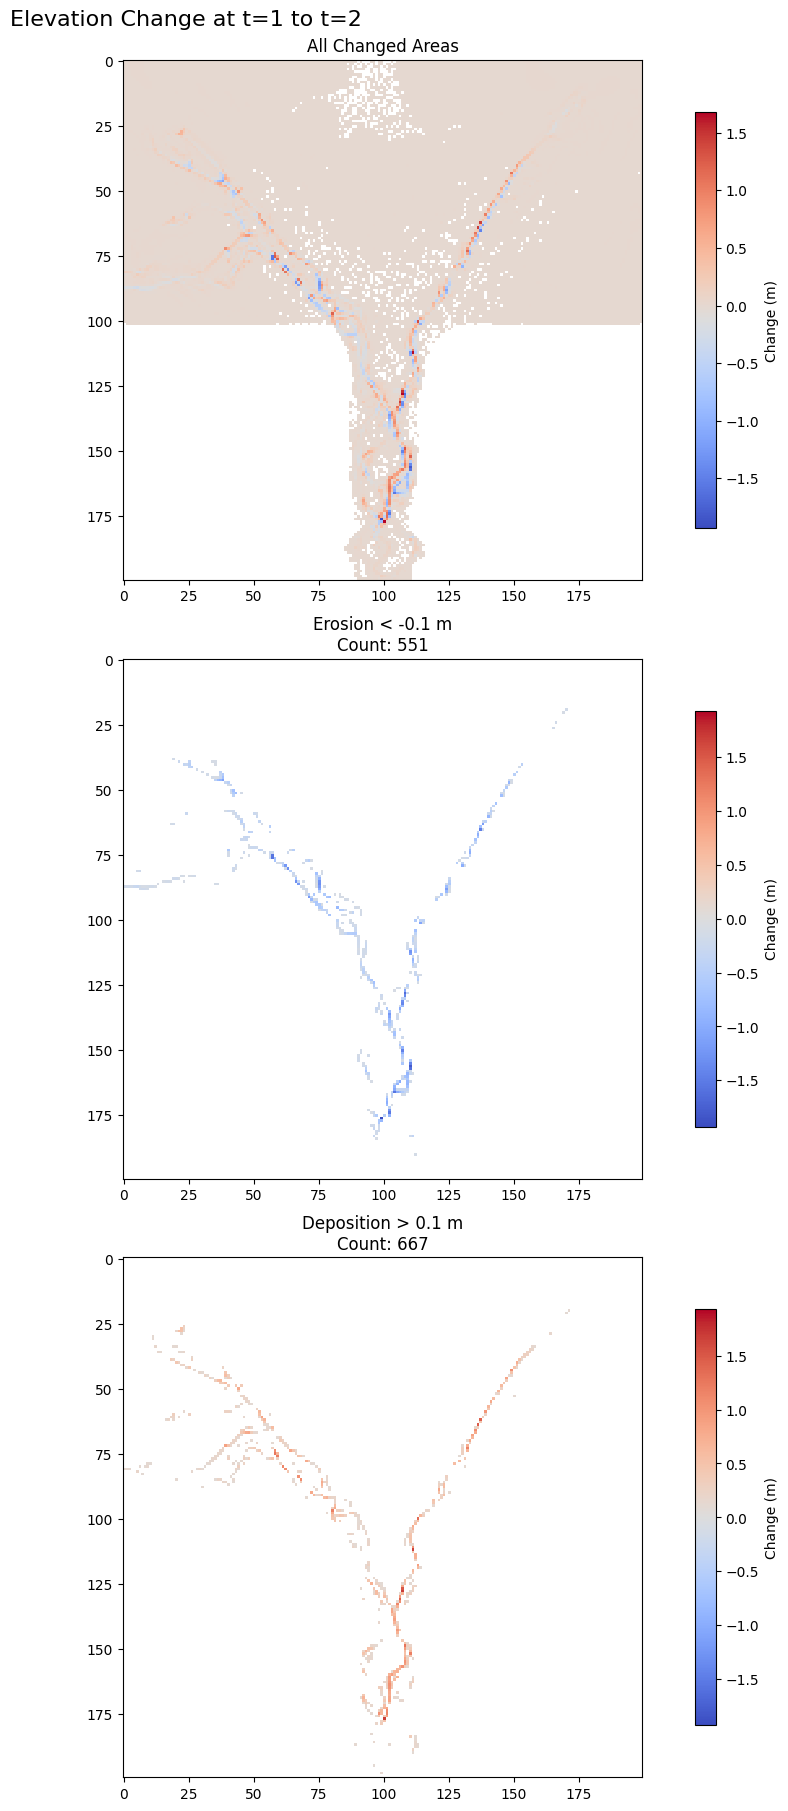

In [22]:
threshold = 0.10

# Load dataset
dataset = xr.open_dataset(trimC)

# Convert depth to elevation
depth1 = dataset["DPS"][:, 1:-1, 1:-1] * -1

# Extract coordinates (optional)
xc = dataset["XCOR"].values[1:-1, 1:-1]
yc = dataset["YCOR"].values[1:-1, 1:-1]

# Choose time index
t = 1
elev1 = depth1[t].values
elev2 = depth1[t + 1].values

# Calculate difference
difference = elev2 - elev1  # positive = deposition, negative = erosion

# Create masks
all_changes = np.where(difference != 0, difference, np.nan)

# Threshold masks
erosion_mask = difference < -threshold
deposition_mask = difference > threshold

# Count cells
erosion_count = np.sum(erosion_mask)
deposition_count = np.sum(deposition_mask)

# Masked arrays for plotting
erosion = np.where(erosion_mask, difference, np.nan)
deposition = np.where(deposition_mask, difference, np.nan)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

# Subplot 1: All changes
im1 = axs[0].imshow(all_changes, cmap="coolwarm", interpolation="none")
axs[0].set_title("All Changed Areas")
axs[0].grid(False)
fig.colorbar(im1, ax=axs[0], shrink=0.8, label="Change (m)")

# Subplot 2: Significant Erosion
im2 = axs[1].imshow(erosion, cmap="coolwarm", interpolation="none", vmin=-np.nanmax(np.abs(difference)), vmax=np.nanmax(np.abs(difference)))
axs[1].set_title(f"Erosion < -{threshold} m\nCount: {erosion_count}")
axs[1].grid(False)
fig.colorbar(im2, ax=axs[1], shrink=0.8, label="Change (m)")

# Subplot 3: Significant Deposition
im3 = axs[2].imshow(deposition, cmap="coolwarm", interpolation="none", vmin=-np.nanmax(np.abs(difference)), vmax=np.nanmax(np.abs(difference)))
axs[2].set_title(f"Deposition > {threshold} m\nCount: {deposition_count}")
axs[2].grid(False)
fig.colorbar(im3, ax=axs[2], shrink=0.8, label="Change (m)")

# Overall title
fig.suptitle(f"Elevation Change at t={t} to t={t+1}", fontsize=16)
plt.show()


This illustrated the change of a single time step. Now this system is put in a loop to loop over the whole time series and safe the erosion and depostion rates per timestep. This is done for all simulations.
# 2. Gather all erosion and depostion data

In [40]:
# Import no dredging data
trimC = "Mahakam_500/Dreding duration/mahakam_control_sim/trim-001.nc"

# Import duration results
trim10 = "Mahakam_500/Dreding duration/10 jaar dredging/trim-001.nc"
trim20 = "Mahakam_500/Dreding duration/20 jaar dredge/trim-001.nc"
trim30 = "Mahakam_500/Dreding duration/30 jaar dredge/trim-001.nc"
trim40 = "Mahakam_500/Dreding duration/40 jaar dredge/trim-001.nc"
trim50 = "Mahakam_500/Dreding duration/50 jaar dredge/trim-001.nc"

# Import intensity resutls
trim0_5 = "Mahakam_500/Dredging_intensity/0.5x_Sed_10_years/trim-001.nc"
trim1_0 = "Mahakam_500/Dredging_intensity/1.0x_Sed_10_years/trim-001.nc"
trim2_0 = "Mahakam_500/Dredging_intensity/2.0x_Sed_10_years/trim-001.nc"
trim5_0 = "Mahakam_500/Dredging_intensity/5.0x_Sed_10_years/trim-001.nc"
trim10_0 = "Mahakam_500/Dredging_intensity/10.0x_Sed_10_years/trim-001.nc"

# Import Grouped results
trimG1 = "Mahakam_500/grouped_pits/10 jaar dredge grouped4/trim-001.nc"
trimG2 = "Mahakam_500/grouped_pits/10 jaar dredge grouped2/trim-001.nc"
trimG4 = trim10 # control, 4 means for locations

# Import Wider results
trimB1 = trim10 # control
trimB2 = "Mahakam_500/grouped_pits/10 jaar dredge 2 broad/trim-001.nc"
trimB3 = "Mahakam_500/grouped_pits/10 jaar dredge 3 broad/trim-001.nc"
trimB4 = "Mahakam_500/grouped_pits/10 jaar dredge 4 broad/trim-001.nc"

# Import Longer Results
trimL1 = trim10 # control
trimL2 = "Mahakam_500/grouped_pits/10 jaar dredge 2 long/trim-001.nc"
trimL3 = "Mahakam_500/grouped_pits/10 jaar dredge 3 long/trim-001.nc"
trimL4 = "Mahakam_500/grouped_pits/10 jaar dredge 4 long/trim-001.nc"

# Make a trim list:
trimlist = [trimC, trim10, trim20, trim30, trim40, trim50, trim0_5, trim1_0, trim2_0, trim5_0, trim10_0, trimG4, trimG2, trimG1, trimB1, trimB2, trimB3, trimB4, trimL1, trimL2, trimL3, trimL4]
trimIDs = ["trimC", "trim10", "trim20", "trim30", "trim40", "trim50",
    "trim0_5", "trim1_0", "trim2_0", "trim5_0", "trim10_0",
    "trimG4", "trimG2", "trimG1",
    "trimB1", "trimB2", "trimB3", "trimB4",
    "trimL1", "trimL2", "trimL3", "trimL4"]

In [26]:
threshold = 0.1

All_erosion = []
All_deposition = []

for trim in trimlist:          # Loop over all the scenarios
    erosionseries = []
    depositionseries = []
    
    dataset = xr.open_dataset(trim)
        
    # Convert depth to elevation
    depth1 = dataset["DPS"][:, 1:-1, 1:-1] * -1
        
    # Extract coordinates (optional)
    xc = dataset["XCOR"].values[1:-1, 1:-1]
    yc = dataset["YCOR"].values[1:-1, 1:-1]
    
    for t in range(1, depth1.shape[0]):     # Loop over the whole simulation timeseries
    
        elev1 = depth1[t-1].values
        elev2 = depth1[t].values
        difference = elev2 - elev1  # positive = deposition, negative = erosion
        
        erosion_mask = difference < -threshold   # Threshold masks
        deposition_mask = difference > threshold  
        
        erosion_count = np.sum(erosion_mask)  # Count cells
        deposition_count = np.sum(deposition_mask)
    
        erosionseries.append(erosion_count)
        depositionseries.append(deposition_count)

    All_erosion.append(erosionseries)
    All_deposition.append(depositionseries)

In [29]:
pixel_area = 50 * 50

In [30]:
# Transpose the data so rows = timesteps, columns = runIDs
df_ERO = pd.DataFrame(All_erosion).T
df_ERO.columns = trimIDs
df_ERO = df_ERO * (365 / 400) * pixel_area
df_ERO

,trimC,trim10,trim20,trim30,trim40,trim50,trim0_5,trim1_0,trim2_0,trim5_0,...,trimG2,trimG1,trimB1,trimB2,trimB3,trimB4,trimL1,trimL2,trimL3,trimL4
0,0.00,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,...,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75,864593.75
1,1256968.75,1152031.25,1152031.25,1152031.25,1152031.25,1152031.25,1136062.50,1152031.25,1131500.00,1225031.25,...,1170281.25,1156593.75,1152031.25,1172562.50,1168000.00,1140625.00,1152031.25,1177125.00,1165718.75,1177125.00
2,1220468.75,1423500.00,1423500.00,1423500.00,1423500.00,1423500.00,1204500.00,1423500.00,1298031.25,1177125.00,...,1291187.50,1323125.00,1423500.00,1259250.00,1259250.00,1341375.00,1423500.00,1320843.75,1215906.25,1186250.00
3,1345937.50,1277500.00,1277500.00,1277500.00,1277500.00,1277500.00,1204500.00,1277500.00,1069906.25,1067625.00,...,1279781.25,1229593.75,1277500.00,1243281.25,1126937.50,1145187.50,1277500.00,1161156.25,1149750.00,1136062.50
4,1266093.75,1282062.50,1282062.50,1282062.50,1282062.50,1282062.50,1366468.75,1282062.50,1177125.00,1304875.00,...,1231875.00,1083593.75,1282062.50,1444031.25,1211343.75,1197656.25,1282062.50,1126937.50,1304875.00,1158875.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1268375.00,732281.25,969531.25,791593.75,1211343.75,1195375.00,1355062.50,732281.25,869156.25,1067625.00,...,1003750.00,1081312.50,732281.25,1074468.75,839500.00,652437.50,732281.25,1375593.75,1243281.25,1174843.75
88,1288906.25,882843.75,935312.50,825812.50,1129218.75,1279781.25,1279781.25,882843.75,832656.25,1056218.75,...,903375.00,1316281.25,882843.75,958125.00,939875.00,693500.00,882843.75,1494218.75,1336812.50,1106406.25
89,1384718.75,880562.50,901093.75,725437.50,1012875.00,1300312.50,1298031.25,880562.50,839500.00,964968.75,...,907937.50,1475968.75,880562.50,1060781.25,937593.75,848625.00,880562.50,1414375.00,1236437.50,976375.00
90,1311718.75,1001468.75,736843.75,825812.50,1142906.25,1263812.50,1371031.25,1001468.75,903375.00,1110968.75,...,923906.25,1311718.75,1001468.75,935312.50,917062.50,926187.50,1001468.75,1368750.00,1154312.50,1019718.75


In [31]:
# Transpose the data so rows = timesteps, columns = runIDs
df_Dep = pd.DataFrame(All_deposition).T
df_Dep.columns = trimIDs
df_Dep = df_Dep * (365 / 400) * pixel_area
df_Dep

,trimC,trim10,trim20,trim30,trim40,trim50,trim0_5,trim1_0,trim2_0,trim5_0,...,trimG2,trimG1,trimB1,trimB2,trimB3,trimB4,trimL1,trimL2,trimL3,trimL4
0,0.00,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,...,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,962687.50,962687.5,962687.50,962687.50
1,1521593.75,1314000.00,1314000.00,1314000.00,1314000.00,1314000.00,1302593.75,1314000.00,1320843.75,1396125.00,...,1332250.00,1336812.50,1314000.00,1332250.00,1357343.75,1323125.00,1314000.00,1355062.5,1350500.00,1414375.00
2,1368750.00,1571781.25,1571781.25,1571781.25,1571781.25,1571781.25,1384718.75,1571781.25,1430343.75,1348218.75,...,1412093.75,1473687.50,1571781.25,1487375.00,1530718.75,1448593.75,1571781.25,1505625.0,1320843.75,1334531.25
3,1368750.00,1384718.75,1384718.75,1384718.75,1384718.75,1384718.75,1286625.00,1384718.75,1359625.00,1238718.75,...,1416656.25,1373312.50,1384718.75,1355062.50,1348218.75,1339093.75,1384718.75,1190812.5,1270656.25,1247843.75
4,1412093.75,1514750.00,1514750.00,1514750.00,1514750.00,1514750.00,1428062.50,1514750.00,1307156.25,1377875.00,...,1309437.50,1307156.25,1514750.00,1674437.50,1325406.25,1329968.75,1514750.00,1213625.0,1393843.75,1288906.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1448593.75,844062.50,974093.75,1033406.25,1341375.00,1361906.25,1336812.50,844062.50,1008312.50,1165718.75,...,1211343.75,1129218.75,844062.50,1124656.25,930750.00,686656.25,844062.50,1510187.5,1307156.25,1272937.50
88,1533000.00,944437.50,926187.50,960406.25,1215906.25,1389281.25,1501062.50,944437.50,860031.25,1147468.75,...,1072187.50,1325406.25,944437.50,1035687.50,985500.00,832656.25,944437.50,1624250.0,1514750.00,1227312.50
89,1544406.25,1076750.00,962687.50,887406.25,1158875.00,1514750.00,1567218.75,1076750.00,919343.75,1122375.00,...,1026562.50,1519312.50,1076750.00,1225031.25,964968.75,958125.00,1076750.00,1587750.0,1327687.50,1097281.25
90,1599156.25,1097281.25,828093.75,928468.75,1318562.50,1387000.00,1596875.00,1097281.25,926187.50,1120093.75,...,937593.75,1377875.00,1097281.25,1161156.25,980937.50,955843.75,1097281.25,1469125.0,1243281.25,1051656.25


# 3. Plot Rate of Change per Simulation

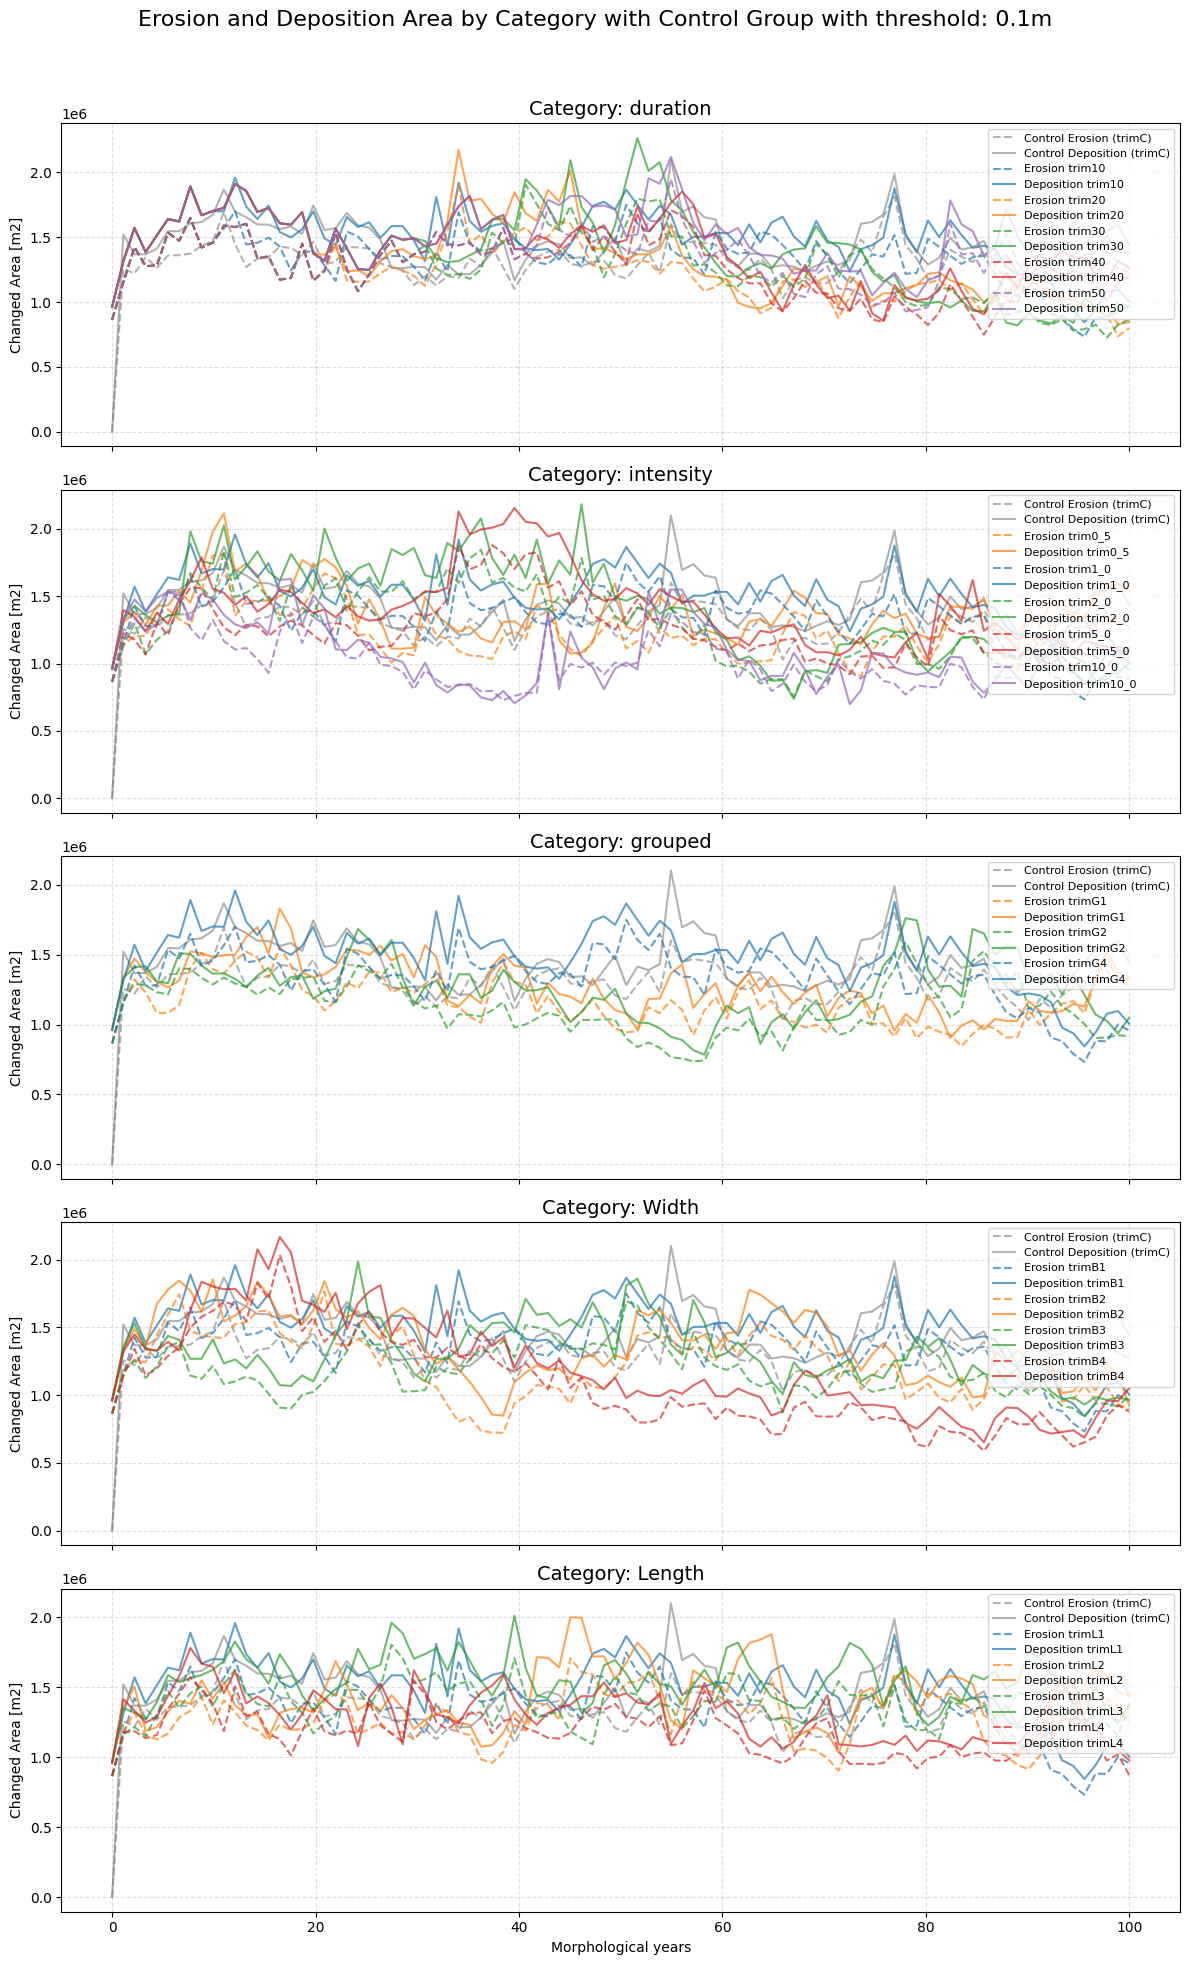

In [36]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
morftime = np.linspace(0, 100, df_Dep.shape[0])


labels = ['trimC', 'trim10', 'trim20', 'trim30', 'trim40', 'trim50', 
          'trim0_5', 'trim1_0', 'trim2_0', 'trim5_0', 'trim10_0', 
          'trimG4', 'trimG2', 'trimG1', 'trimB1', 'trimB2', 'trimB3', 
          'trimB4', 'trimL1', 'trimL2', 'trimL3', 'trimL4']

categories = {
    'duration': ['trim10', 'trim20', 'trim30', 'trim40', 'trim50'],
    'intensity': ['trim0_5', 'trim1_0', 'trim2_0', 'trim5_0', 'trim10_0'],
    'grouped': ['trimG1', 'trimG2', 'trimG4'],
    'Width': ['trimB1', 'trimB2', 'trimB3', 'trimB4'],
    'Length': ['trimL1', 'trimL2', 'trimL3', 'trimL4'],
}

# Define unique color palettes for each category
color_cycles = {
    'duration': ['C0', 'C1', 'C2', 'C3', 'C4'],
    'intensity': ['C1', 'C0', 'C2', 'C3', 'C4'],
    'grouped': ['C1', 'C2', 'C0'],
    'Length': ['C0', 'C1', 'C2', 'C3'],
    'Width': ['C0', 'C1', 'C2', 'C3']
}

fig, axs = plt.subplots(len(categories), 1, figsize=(12, 4*len(categories)), sharex=True)

for ax, (cat, cat_labels) in zip(axs, categories.items()):
    colors = color_cycles[cat]
    
    # Plot control group first in grey if exists
    if 'trimC' in df_ERO.columns and 'trimC' in df_Dep.columns:
        erosion_ctrl = df_ERO['trimC']
        deposition_ctrl = df_Dep['trimC']
        ax.plot(morftime, erosion_ctrl, linestyle='--', color='grey', alpha=0.6, label='Control Erosion (trimC)')
        ax.plot(morftime, deposition_ctrl, linestyle='-', color='grey', alpha=0.6, label='Control Deposition (trimC)')
    
    for i, label in enumerate(cat_labels):
        if label not in df_ERO.columns or label not in df_Dep.columns:
            continue

        color = colors[i % len(colors)]
        erosion_series = df_ERO[label]
        deposition_series = df_Dep[label]

        ax.plot(morftime, erosion_series, linestyle='--', color=color, alpha=0.7, label=f'Erosion {label}')
        ax.plot(morftime, deposition_series, linestyle='-', color=color, alpha=0.7, label=f'Deposition {label}')
    
    ax.set_title(f"Category: {cat}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel('Changed Area [m2]')
    ax.legend(fontsize=8, loc='upper right')

axs[-1].set_xlabel('Morphological years')

fig.suptitle(f"Erosion and Deposition Area by Category with Control Group with threshold: {threshold}m", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig(f"C:/Users/camup/Documents/aaMEE/Master thesis/figures/ErosionDepoAreaPerGRoupWith{threshold}mThreshold.png", bbox_inches='tight', dpi=400)
plt.show()
